# Atividade 6 - Classificador Naive Bayes com ReliefF

Realizar validação cruzada para testar naiveBayes utilizando:

    - todas a características
    - apenas com os componentes principais
    - apenas com as características selecionadas pelo selecionador 1
    - apenas com as características selecionadas pelo selecionador 2
    
● Dependendo do seu dataset (tipos de variáveis) dá para utilizar uma implementação pronta de Naive Bayes ou ter que implementar a sua (talvez dê para combinar diferentes implementações)

● Quem tem missing values – possibilidade de não tratar antes e deixar isso para o algoritmo EM

● Para cada dataset fazer:

● Calibração do parâmetro utilizado na estimação MAP (no mínimo 2 valores: 0.1 e 1) via validação cruzada 10x – escolher aquele que apresentar maior acurácia média;

● Calcular os valores médios de revocação (sensibilidade), precisão e acurácia.

In [72]:
# imports

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from pandas import read_csv
from sklearn.model_selection import StratifiedKFold
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html

#normalizacao
from sklearn import preprocessing

# Modelagem
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

# Classificador
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB


# Balanceamento das classes
from imblearn.combine import SMOTETomek

# Validação
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from scipy import stats as st


import warnings

warnings.filterwarnings("ignore")

random_state=5007

In [73]:
# importa dataset

df = read_csv('../data/kag_risk_factors_cervical_cancer.csv')

print(df.shape)

#df.head()

(858, 36)


### Características selecionadas pelo ReliefF na atividade 4

In [74]:
selecionadas_continuas = [ 'Age',
                           'Num of pregnancies',
                           'Hormonal Contraceptives (years)',
                           'First sexual intercourse',
                           'STDs (number)',
                           'STDs: Number of diagnosis'] 

selecionadas_binarias = ['Hinselmann',
                        'Schiller',
                        'Citology', 
                        'STDs'
                        ]

## Pré-Processamento

In [75]:
# substituindo ? por NAN
df.replace('?', np.NAN,inplace=True)

In [76]:
# Transforma as feature em numericas
df_processed = df.apply(pd.to_numeric, errors="ignore")

# Resultado final com as devidas alteracoes
#df_processed.info() 

## Eliminação (ou não) de instâncias com missing values

Para features continuas --> preenche com a mediana (para nao ter muito impacto com outliers)

Hipotese:
 - Para features categoricas --> preenche com o valor mais frequente
 
No decorrer dos experimentos validar se a hipotese é aceita ou não.

(Uma alternativa seria imputar os valores pelo moda (valor mais frequente), que provavelmente é uma solução ruim, pois a resposta verdadeira pode estar correlacionada com a probabilidade de um valor estar ausente. Pois isso teremos um bias, pois esses valores são privados e a pessoa pode escolher não divulga-los)

In [77]:
continuous_feat = ['Age',
                   'Number of sexual partners',
                   'First sexual intercourse',
                   'Num of pregnancies', 
                   'Smokes (years)',
                   'Smokes (packs/year)',
                   'Hormonal Contraceptives (years)',
                   'IUD (years)',
                   'STDs (number)',
                   'STDs: Number of diagnosis',
                   'STDs: Time since first diagnosis',
                   'STDs: Time since last diagnosis'] 

binary_feat = [  'Smokes',
                 'Hormonal Contraceptives',
                 'IUD',
                 'STDs',
                 'STDs:condylomatosis',
                 'STDs:cervical condylomatosis',
                 'STDs:vaginal condylomatosis',
                 'STDs:vulvo-perineal condylomatosis',
                 'STDs:syphilis',
                 'STDs:pelvic inflammatory disease',
                 'STDs:genital herpes',
                 'STDs:molluscum contagiosum',
                 'STDs:AIDS',
                 'STDs:HIV',
                 'STDs:Hepatitis B',
                 'STDs:HPV',
                 'Dx:Cancer',
                 'Dx:CIN',
                 'Dx:HPV',
                 'Dx',
                 'Hinselmann',
                 'Schiller',
                 'Citology']                               


In [78]:
df_imp = df_processed.copy()

In [79]:
# preenche com a mediana
imp_median = SimpleImputer(missing_values = np.nan, strategy = 'median')
df_imp[continuous_feat] = imp_median.fit_transform(df_processed[continuous_feat])

# preenche com o valor mais frequente
imp_most_freq = SimpleImputer(missing_values = np.nan, strategy = 'most_frequent')
df_imp[binary_feat] = imp_most_freq.fit_transform(df_processed[binary_feat])

#df_imp.isnull().sum()


## Stratified Cross- Validation

### Dataset Desbalanceado

In [80]:
# Cross Validation com dataset DESBALANCEADO

def stratified_k_fold(df, k, random_state,alpha_min = 0.1, alpha_max = 1, alpha_step = 0.1, shuffle=False):
    # Utilizando todas as features como preditoras
    X = df.drop('Biopsy', axis=1)
    y = df['Biopsy']
    
    # quantidade original de classes
    count_classes = y.value_counts()
    
    # Stratified K Fold
    skf = StratifiedKFold(n_splits=k, shuffle=shuffle, random_state=random_state)
    skf.get_n_splits(X, y)
    print('k = {}, Dataset {} positivas e {} negativas ({:.2f}% x {:.2f}%)'.format(k, count_classes[1], 
                                                                                 count_classes[0], 
                                                                                 ((count_classes[1]/len(y))*100), 
                                                                                 ((count_classes[0]/len(y))*100)))
    

    
    # Scores (das futuras metricas)
    scores = []

    alpha_min = int(alpha_min*100)
    alpha_max = int(alpha_max*100 +1)
    alpha_step = int(alpha_step*100)
    
    # Testa varios alphas
    for alpha_int in range (alpha_min, alpha_max, alpha_step):
        alpha = alpha_int * 0.01
        
        #Naive Bayes
        gnb = GaussianNB(var_smoothing=alpha)
        bnb = BernoulliNB(alpha=alpha)
        
        # Folds
        for fold, (train_index, test_index) in enumerate(skf.split(X, y), 1):
            fold_number = fold
            X_train, y_train = X.iloc[train_index], y.iloc[train_index]
            X_test, y_test = X.iloc[test_index], y.iloc[test_index]

            # quantidade de classes dentro da fold
            count_classes_fold = y.iloc[test_index].value_counts()
            # proporções
            prop_pos = ((count_classes_fold[1]/count_classes_fold.sum())*100)
            prop_neg = ((count_classes_fold[0]/count_classes_fold.sum())*100)
            print('Fold {}: Pos: {}, Neg: {}, Total: {}, Proporção: {:.2f}% x {:.2f}%'.format(fold_number, 
                                                                                count_classes_fold[1],
                                                                                count_classes_fold[0], 
                                                                                count_classes_fold.sum(),
                                                                                prop_pos, prop_neg))

            # aplica Gaussian Naive Bayes em features continuas e Bernoulli Naive Bayes em binarias
            y_pred_g = gnb.fit(X_train[selecionadas_continuas], y_train)
            y_pred_b = bnb.fit(X_train[selecionadas_binarias], y_train)
            
            # Cria novo Dataset em que features são probabilidade da classe ser 1 para cada um dos classificadores (Gaussian e Bernoulli) 
            X_probs = pd.DataFrame(np.hstack((y_pred_g.predict_proba(X_train[selecionadas_continuas]), y_pred_b.predict_proba(X_train[selecionadas_binarias]))),
                        columns = ['0_G','1_G','0_B','1_B'])            
            
            X_probs_test = pd.DataFrame(np.hstack((y_pred_g.predict_proba(X_test[selecionadas_continuas]), y_pred_b.predict_proba(X_test[selecionadas_binarias]))),
                        columns = ['0_G','1_G','0_B','1_B'])
            
            # Aplica um novo Gaussian Naive Bayes sobre o novo dataset e classifica fold de teste
            y_pred = gnb.fit(X_probs, y_train).predict(X_probs_test)
            print("\tNumero de instancias classificadas erradas do total de %d instancias : %d"
             % (X_probs_test.shape[0], (y_test != y_pred).sum()))
           # print("Number of points predicted as Pos: %d"
           #  % ((y_pred == 1).sum()))

            # Scores do model (utilizados dados nao-balanceados) - dados de teste
            recall = recall_score(y_test, y_pred)
            accuracy = accuracy_score(y_test, y_pred)
            precision = precision_score(y_test, y_pred)
            scores.append([alpha, fold_number, precision, recall, accuracy])
            
    return np.array(scores)
    



### Dataset Balanceado

In [81]:
# Cross Validation com dataset BALANCEADO (SMOTETomek)

def stratified_k_fold_SMOTE(df, k, random_state, alpha_min = 0.1, alpha_max = 1, alpha_step = 0.1, shuffle=False):
    # Utilizando todas as features como preditoras
    X = df.drop('Biopsy', axis=1)
    y = df['Biopsy']
    # quantidade original de classes
    count_classes = y.value_counts()
    # Stratified K Fold
    skf = StratifiedKFold(n_splits=k, shuffle=shuffle, random_state=random_state)
    skf.get_n_splits(X, y)
    print('k = {}, Dataset (desbalanceado) {} positivas e {} negativas ({:.2f}% x {:.2f}%)'.format(k, count_classes[1], 
                                                                                 count_classes[0], 
                                                                                 ((count_classes[1]/len(y))*100), 
                                                                                 ((count_classes[0]/len(y))*100)))
   
    # Normalização MinMax
    minmax_scale = preprocessing.MinMaxScaler(feature_range=(0, 1))
    
    # SMOTETomek
    cc = SMOTETomek(random_state=random_state)

    # Scores (das futuras metricas)
    scores = []

    alpha_min = int(alpha_min*100)
    alpha_max = int(alpha_max*100 +1)
    alpha_step = int(alpha_step*100)
    
    # Testa varios alphas
    for alpha_int in range (alpha_min, alpha_max, alpha_step):
        alpha = alpha_int * 0.01
        
        #Naive Bayes
        gnb = GaussianNB(var_smoothing=alpha)
        bnb = BernoulliNB(alpha=alpha)
        
        # Folds
        for fold, (train_index, test_index) in enumerate(skf.split(X, y), 1):
            fold_number = fold
            X_train, y_train = X.iloc[train_index], y.iloc[train_index]
            X_test, y_test = X.iloc[test_index], y.iloc[test_index]

            # Normaliza MinMax para aplicar Smote
            X_train_normalized = minmax_scale.fit_transform(X_train)
            X_train_normalized = pd.DataFrame(X_train_normalized, columns = X.columns.tolist())

            # SMOTETomek (apenas os dados de treino)
            print('\tBalanceando dados de treino fold {}...'.format(fold_number))
            X_train, y_train = cc.fit_resample(X_train_normalized, y_train)
            
            # Retorna para valores não normalizados
            X_train = pd.DataFrame(minmax_scale.inverse_transform(X_train), columns = X.columns.tolist())
            print('\t\tFold = {}, Dataset (balanceado) {} positivas e {} negativas ({:.2f}% x {:.2f}%)'.format(fold_number, 
                                                                                     y_train.value_counts()[0], 
                                                                                     y_train.value_counts()[1], 
                                                                                     ((y_train.value_counts()[0]/len(y_train))*100), 
                                                                                     ((y_train.value_counts()[1]/len(y_train))*100)))
            # quantidade de classes dentro da fold
            count_classes_fold = y_test.value_counts()
            # proporções
            prop_pos = ((count_classes_fold[1]/count_classes_fold.sum())*100)
            prop_neg = ((count_classes_fold[0]/count_classes_fold.sum())*100)
            print('\t\tDados de teste (desbalanceados)')
            print('\t\tFold {}: Pos: {}, Neg: {}, Total: {}, Proporção: {:.2f}% x {:.2f}%'.format(fold_number, 
                                                                                count_classes_fold[1],
                                                                                count_classes_fold[0], 
                                                                                count_classes_fold.sum(),
                                                                                prop_pos, prop_neg))


            # aplica Gaussian Naive Bayes em features continuas e Bernoulli Naive Bayes em binarias
            y_pred_g = gnb.fit(X_train[selecionadas_continuas], y_train)
            y_pred_b = bnb.fit(X_train[selecionadas_binarias], y_train)
            
            # Cria novo Dataset em que features são probabilidade da classe ser 1 para cada um dos classificadores (Gaussian e Bernoulli) 
            X_probs = pd.DataFrame(np.hstack((y_pred_g.predict_proba(X_train[selecionadas_continuas]), y_pred_b.predict_proba(X_train[selecionadas_binarias]))),
                       columns = ['0_G','1_G','0_B','1_B'])
            X_probs_test = pd.DataFrame(np.hstack((y_pred_g.predict_proba(X_test[selecionadas_continuas]), y_pred_b.predict_proba(X_test[selecionadas_binarias]))),
                                                  columns = ['0_G','1_G','0_B','1_B'])
            
            # Aplica um novo Gaussian Naive Bayes sobre o novo dataset e classifica fold de teste
            y_pred = gnb.fit(X_probs, y_train).predict(X_probs_test)
            print("\t\t\tNumero de instancias classificadas erradas do total de %d instancias : %d"
             % (X_probs_test.shape[0], (y_test != y_pred).sum()))
           # print("Number of points predicted as Pos: %d"
           #  % ((y_pred == 1).sum()))

            # Scores do model (utilizados dados nao-balanceados) - dados de teste
            recall = recall_score(y_test, y_pred)
            accuracy = accuracy_score(y_test, y_pred)
            precision = precision_score(y_test, y_pred)
            scores.append([alpha, fold_number, precision, recall, accuracy])
            
    return np.array(scores)


## Calculando Precisão, Revocação e Acurácia

In [82]:
df_selecionado = df_imp[selecionadas_continuas]
df_selecionado = df_selecionado.join(df_imp[selecionadas_binarias])
df_selecionado = df_selecionado.join(df_imp['Biopsy'])

#df_selecionado

### Dataset Desbalanceado

In [83]:
k = 10
print('K-Fold com K = {}'.format(k))
scores_unbalanced = pd.DataFrame(stratified_k_fold(df_selecionado, k, random_state,alpha_min = 0.1, alpha_max = 1, alpha_step = 0.1, shuffle=False))
scores_unbalanced = scores_unbalanced.rename(columns = {0: 'Alpha', 1:'Fold', 2: 'Precision', 3: 'Recall', 4: 'Accuracy'}) 
print('----'*20)

K-Fold com K = 10
k = 10, Dataset 55 positivas e 803 negativas (6.41% x 93.59%)
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
	Numero de instancias classificadas erradas do total de 86 instancias : 10
Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
	Numero de instancias classificadas erradas do total de 86 instancias : 1
Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
	Numero de instancias classificadas erradas do total de 86 instancias : 4
Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
	Numero de instancias classificadas erradas do total de 86 instancias : 1
Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
	Numero de instancias classificadas erradas do total de 86 instancias : 7
Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
	Numero de instancias classificadas erradas do total de 86 instancias : 1
Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
	Numero de instancias classificadas errad

In [84]:
scores_unbalanced.head()

,Alpha,Fold,Precision,Recall,Accuracy
0,0.1,1.0,0.333333,1.000000,0.883721
1,0.1,2.0,0.833333,1.000000,0.988372
2,0.1,3.0,0.571429,0.800000,0.953488
3,0.1,4.0,1.000000,0.833333,0.988372
4,0.1,5.0,0.428571,0.500000,0.918605


### Dataset Balanceado

In [85]:
k = 10
print('K-Fold com K = {}'.format(k))
scores_balanced = pd.DataFrame(stratified_k_fold_SMOTE(df_selecionado, k, random_state,alpha_min = 0.1, alpha_max = 1, alpha_step = 0.1, shuffle=False))
scores_balanced = scores_balanced.rename(columns = {0: 'Alpha', 1:'Fold', 2: 'Precision', 3: 'Recall', 4: 'Accuracy'}) 
print('----'*20)

K-Fold com K = 10
k = 10, Dataset (desbalanceado) 55 positivas e 803 negativas (6.41% x 93.59%)
	Balanceando dados de treino fold 1...
		Fold = 1, Dataset (balanceado) 718 positivas e 718 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
			Numero de instancias classificadas erradas do total de 86 instancias : 4
	Balanceando dados de treino fold 2...
		Fold = 2, Dataset (balanceado) 719 positivas e 719 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
			Numero de instancias classificadas erradas do total de 86 instancias : 3
	Balanceando dados de treino fold 3...
		Fold = 3, Dataset (balanceado) 719 positivas e 719 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
			Numero de instancias classificadas erradas do total de 86 instancias : 4
	Balanceando dados de 

In [86]:
scores_balanced.head()

,Alpha,Fold,Precision,Recall,Accuracy
0,0.1,1.0,0.555556,1.000000,0.953488
1,0.1,2.0,0.625000,1.000000,0.965116
2,0.1,3.0,0.571429,0.800000,0.953488
3,0.1,4.0,0.857143,1.000000,0.988372
4,0.1,5.0,0.400000,0.666667,0.906977


## Calculando valor de alpha com maior acurácia

### Dataset Desbalanceado

In [87]:
mean_unbalanced = scores_unbalanced.groupby(['Alpha']).mean().drop('Fold', axis = 1)
mean_unbalanced

,Precision,Recall,Accuracy
Alpha,,,
0.1,0.669524,0.753333,0.951040
0.2,0.705000,0.716667,0.958030
0.3,0.719286,0.696667,0.960369
0.4,0.753810,0.696667,0.962722
0.5,0.753810,0.696667,0.962722
0.6,0.753810,0.696667,0.962722
0.7,0.753810,0.696667,0.962722
0.8,0.753810,0.696667,0.962722
0.9,0.753810,0.696667,0.962722


In [88]:
max_alpha_unbalanced = mean_unbalanced['Accuracy'].idxmax()
max_alpha_unbalanced

0.4

### Dataset Balanceado

In [89]:
mean_balanced = scores_balanced.groupby(['Alpha']).mean().drop('Fold', axis = 1)
mean_balanced

,Precision,Recall,Accuracy
Alpha,,,
0.1,0.652302,0.876667,0.956895
0.2,0.652302,0.876667,0.956895
0.3,0.652302,0.876667,0.956895
0.4,0.652302,0.876667,0.956895
0.5,0.652302,0.876667,0.956895
0.6,0.652302,0.876667,0.956895
0.7,0.652302,0.876667,0.956895
0.8,0.652302,0.876667,0.956895
0.9,0.652302,0.876667,0.956895


In [90]:
max_alpha_balanced = mean_balanced['Accuracy'].idxmax()
max_alpha_balanced

0.1

## Calculando intervalo de confiança da Acurácia para o melhor alpha

### Dataset Desbalanceado

In [91]:
# Usando apenas folds com o melhor alpha
accuracies_unbalanced = scores_unbalanced.loc[scores_unbalanced['Alpha'] == max_alpha_unbalanced, 'Accuracy']
mean_unbalanced = np.mean(accuracies_unbalanced)

# Calculo do ic
ic_min_unbalanced, ic_max_unbalanced = st.t.interval(0.95, len(accuracies_unbalanced)-1, loc=mean_unbalanced, scale=st.sem(accuracies_unbalanced))  

print('Média = {}, IC = [{}, {}]'.format(mean_unbalanced,ic_min_unbalanced, ic_max_unbalanced))

Média = 0.9627222982216141, IC = [0.9457360543300902, 0.9797085421131381]


### Dataset Balanceado

In [92]:
# Usando apenas folds com o melhor alpha
accuracies_balanced = scores_balanced.loc[scores_balanced['Alpha'] == max_alpha_balanced, 'Accuracy']
mean_balanced = np.mean(accuracies_balanced)

# Calculo do ic
ic_min_balanced, ic_max_balanced = st.t.interval(0.95, len(accuracies_balanced)-1, loc=mean_balanced, scale=st.sem(accuracies_balanced))  

print('Média = {}, IC = [{}, {}]'.format(mean_balanced,ic_min_balanced, ic_max_balanced))

Média = 0.9568946648426813, IC = [0.9393164145576469, 0.9744729151277156]


## Gráfico

In [93]:
#https://stackoverflow.com/a/44542112
def change_width(ax, new_value) :
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value

        # we change the bar width
        patch.set_width(new_value)

        # we recenter the bar
        patch.set_x(patch.get_x() + diff * .5)


### Dataset Desbalanceado

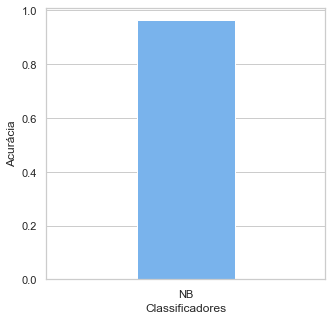

In [94]:
plot_unbalanced = pd.DataFrame(scores_unbalanced.loc[scores_unbalanced['Alpha'] == max_alpha_unbalanced, ['Alpha','Accuracy']])

sns.set(style="whitegrid")
plt.rcParams.update({'font.size': 15})
plt.figure(figsize=(5, 5))

ax_unbalanced = sns.barplot(x="Alpha", y="Accuracy", data=plot_unbalanced, color='#66b3ff', ci = None)
ticks = ['NB']
ax_unbalanced.set(xticklabels=ticks, xlabel='Classificadores', ylabel='Acurácia')

# IC calculado pelo seaborn parece não ser t student
#plt.errorbar(x=[0],y=mean_unbalanced,yerr= (ic_max_unbalanced - mean_unbalanced) , fmt='none')

change_width(ax_unbalanced, .35)

### Dataset Balanceado

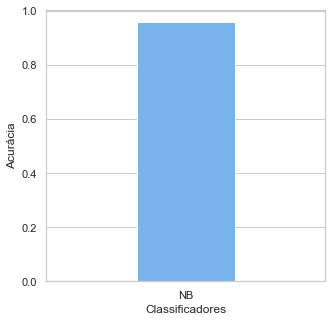

In [95]:
plot_balanced = pd.DataFrame(scores_balanced.loc[scores_balanced['Alpha'] == max_alpha_balanced, ['Alpha','Accuracy']])

sns.set(style="whitegrid")
plt.rcParams.update({'font.size': 15})
plt.figure(figsize=(5, 5))

ax_balanced = sns.barplot(x="Alpha", y="Accuracy", data=plot_balanced, color='#66b3ff', ci = None)
ax_balanced.set(xticklabels=ticks, xlabel='Classificadores', ylabel='Acurácia')

# IC calculado pelo seaborn parece não ser t student
#plt.errorbar(x=[0],y=mean_balanced,yerr= (ic_max_balanced - mean_balanced) , fmt='none')

change_width(ax_balanced, .35)